In [55]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import _add_deltas, split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import add_era_bucket, add_history_coverage, cast_feature_dtypes, pull_data, pull_projections
from modeling import calculate_productivity_score, split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import batting_stat_cols, pitching_stat_cols, batting_career_cols, pitching_career_cols, POS_DAMPENING_MAP
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
AGG_YEARS = 3
MODEL_WEIGHT = 0.65
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.33
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.32

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

In [56]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_career_cols=batting_career_cols,
    pitching_career_cols=pitching_career_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
)

# Additional feature engineering
# Calculate deltas for core stats over the aggregation window
# Calculate player productivity score (how effective are they relative to their age)
# Ensure proper data types for modeling
batting_df = (
    batting_df
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=batting_career_cols)
    .pipe(calculate_productivity_score, agg_years=AGG_YEARS)
    .pipe(add_era_bucket)
    .pipe(add_history_coverage, agg_years=AGG_YEARS)
    .pipe(cast_feature_dtypes)
)
pitching_df = (
    pitching_df
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=pitching_career_cols)
    .pipe(calculate_productivity_score, agg_years=AGG_YEARS)
    .pipe(add_era_bucket)
    .pipe(add_history_coverage, agg_years=AGG_YEARS)
    .pipe(cast_feature_dtypes)
)

# Defining the prediction data for batters & pitchers
batting_pred = batting_df[batting_df["Season"] == END_YEAR].copy()
pitching_pred = pitching_df[pitching_df["Season"] == END_YEAR].copy()
# Dropping the prediction year from the training data
batting_df = batting_df[batting_df["Season"] < END_YEAR].copy()
pitching_df = pitching_df[pitching_df["Season"] < END_YEAR].copy()

# Filter out players with negative future fantasy points (will not be fantasy draft eligible regardless)
batting_df = batting_df[batting_df["fantasy_points_future"] > 0].copy()
pitching_df = pitching_df[pitching_df["fantasy_points_future"] > 0].copy()

Loaded existing data files.


# Pulling FantasyPros Projection Data

In [57]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [58]:
display(batting_projections.head())

first_name last_name Team    Positions  projected_fantasy_points
0     shohei    ohtani  LAD        SP,DH                      1765
1      aaron     judge  NYY  LF,CF,RF,DH                      1721
2      bobby      witt   KC           SS                      1540
3       juan      soto  NYM        LF,RF                      1643
4     ronald     acuna  ATL           RF                      1536

# Defining Baseline Model

## Creating baseline batting predictions

In [59]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 317.719 | MAE: 247.222 | R^2: 0.495


In [60]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
1175            Aaron Judge                 1951.0               1566.400391   
1630            David Ortiz                 1775.0               1565.777344   
1524  Vladimir Guerrero Jr.                 1424.0               1550.519775   
174          Miguel Cabrera                 1747.0               1543.215576   
410         Jackson Merrill                  932.0               1540.787598   
...                     ...                    ...                       ...   
474              Jose Urena                   16.0                 22.222126   
630             Paul Maholm                   37.0                 21.941984   
1039         Bronson Arroyo                   38.0                 17.045347   
1135         Ryan Vogelsong                   40.0                 12.599242   
935           Braden Looper                   64.0                 -4.431501   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1175      -384.599609     384.599609    2024   32            2057  
1630      -209.222656     209.222656    2006   30            1832  
1524       126.519775     126.519775    2024   25            1585  
174       -203.784424     203.784424    2012   29            1762  
410        608.787598     608.787598    2024   21            1265  
...               ...            ...     ...  ...             ...  
474          6.222126       6.222126    2017   25              28  
630        -15.058016      15.058016    2008   26              56  
1039       -20.954653      20.954653    2008   31              88  
1135       -27.400758      27.400758    2011   33              66  
935        -68.431501      68.431501    2008   33              92  

[1671 rows x 8 columns]

# Building Final Model

In [61]:
MAX_DEPTH_CHOICES = [4, 5, 6, 7]

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.025), np.log(0.2)),
    "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
    "subsample": hp.uniform("subsample", 0.6, 1.00),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 0.95),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(15.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(10.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-4), np.log(3.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-3), np.log(2.0)),
}

# Batting Predictions

In [62]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=60,
    random_state=4202020,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 60/60 [01:31<00:00,  1.53s/trial, best loss: 295.3124877758313] 
Best Parameters: {'learning_rate': 0.12979311979672076, 'max_depth': 5, 'subsample': 0.9227817358877478, 'colsample_bytree': 0.8443859047605282, 'min_child_weight': 4.004801332887409, 'reg_lambda': 0.6066583491318428, 'reg_alpha': 0.00048071582465729655, 'gamma': 0.10431697261056389}
[Best trial @ val] optimized=rmse | RMSE=295.312 | MAE=230.436 | ASYM=110840.418


In [63]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202020,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 33
[Val] RMSE: 295.312 | MAE: 230.436 | R^2: 0.571 | ASYM: 110840.418
[Test] RMSE: 313.573 | MAE: 246.325 | R^2: 0.508 | ASYM: 124937.247


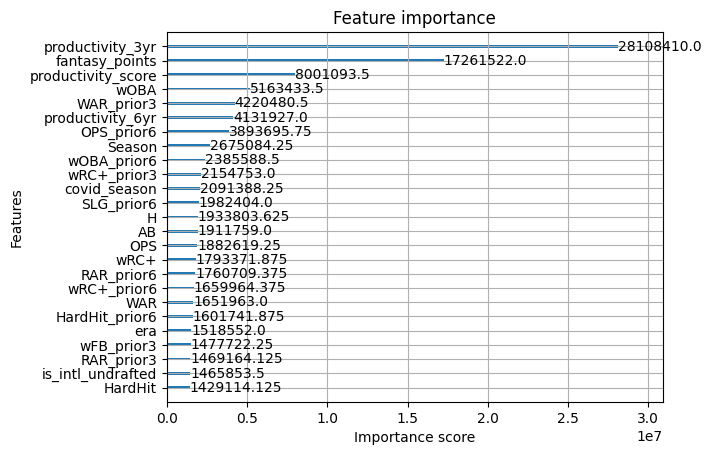

In [64]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [65]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

Name  fantasy_points_future  predicted_fantasy_points  \
1090  Shohei Ohtani                 1933.0               1762.745483   
1630    David Ortiz                 1775.0               1683.086304   
1175    Aaron Judge                 1951.0               1617.666748   
1230  Albert Pujols                 1504.0               1545.941284   
890   Matt Holliday                 1857.0               1537.587524   
...             ...                    ...                       ...   
1118   Tim Lincecum                   27.0                 45.125397   
632       Ted Lilly                   33.0                 45.125397   
295     Paul Maholm                   23.0                 45.125397   
757    Tim Lincecum                   44.0                 43.014687   
936     Cole Hamels                   48.0                 31.295473   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1090      -170.254517     170.254517    2024   29            2143  
1630       -91.913696      91.913696    2006   30            1832  
1175      -333.333252     333.333252    2024   32            2057  
1230        41.941284      41.941284    2010   30            1808  
890       -319.412476     319.412476    2006   26            1678  
...               ...            ...     ...  ...             ...  
1118        18.125397      18.125397    2013   29              40  
632         12.125397      12.125397    2010   34              22  
295         22.125397      22.125397    2009   27              37  
757         -0.985313       0.985313    2009   25              73  
936        -16.704527      16.704527    2009   25              65  

[1671 rows x 8 columns]

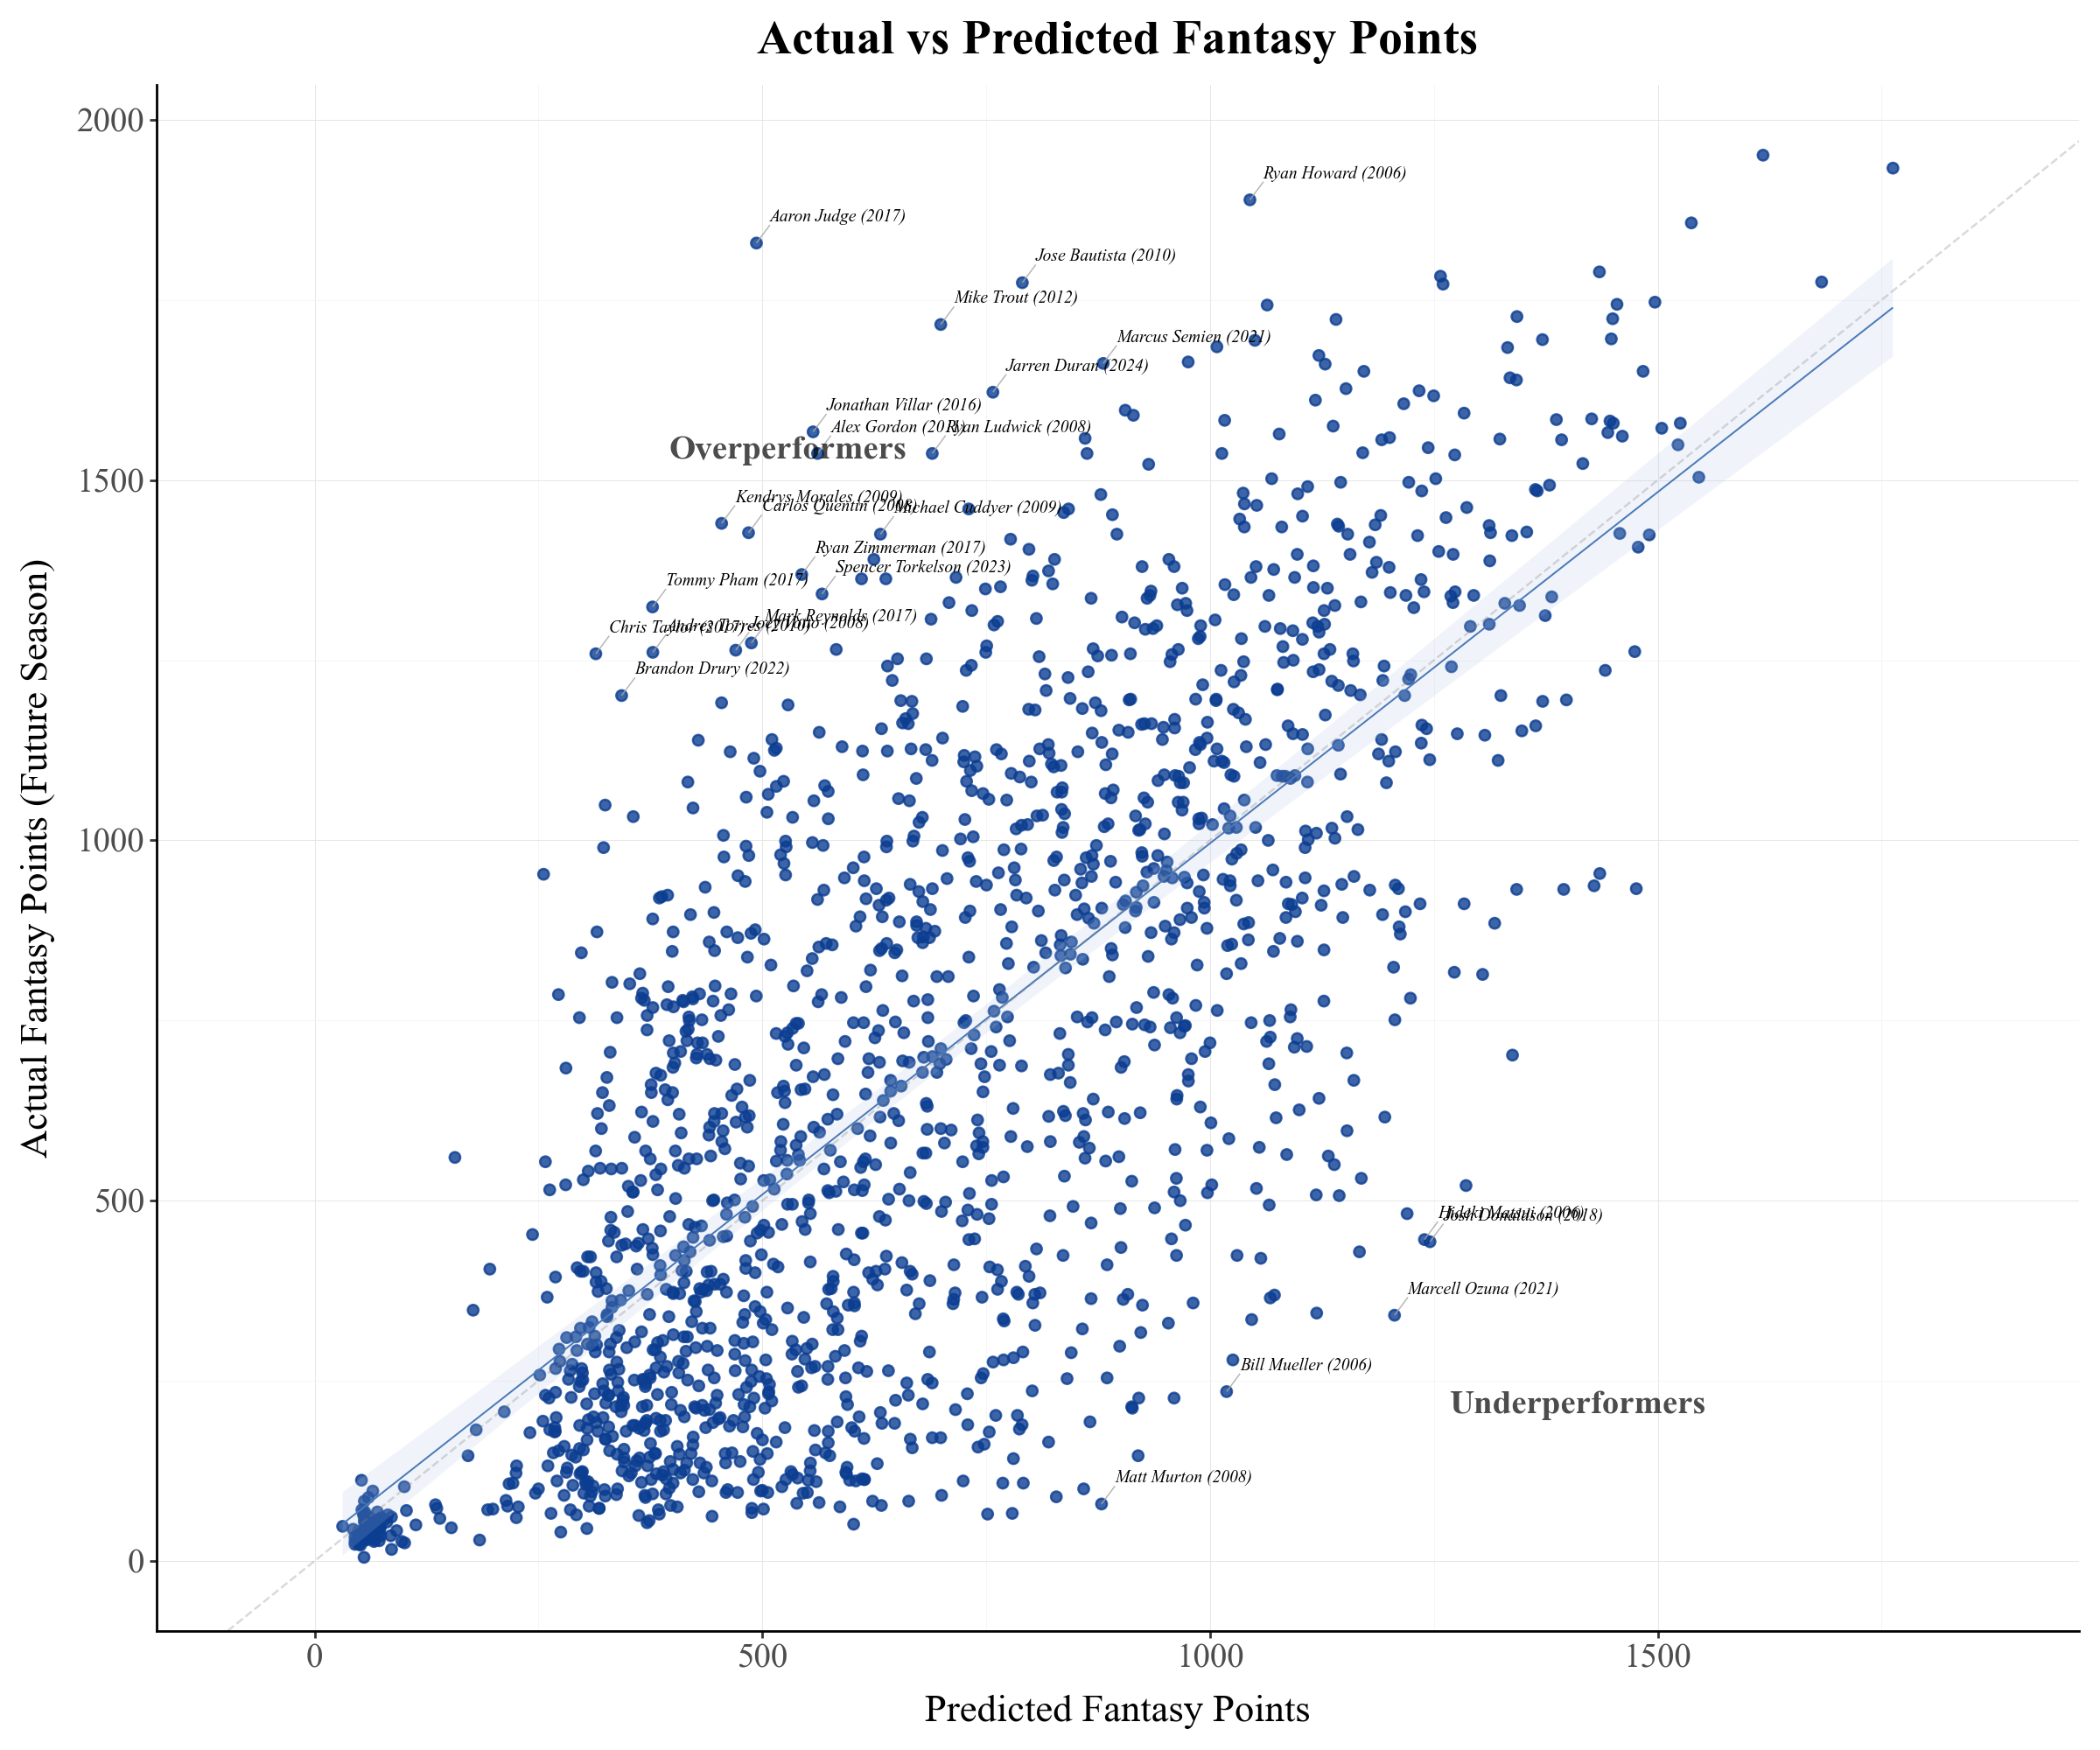

In [66]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

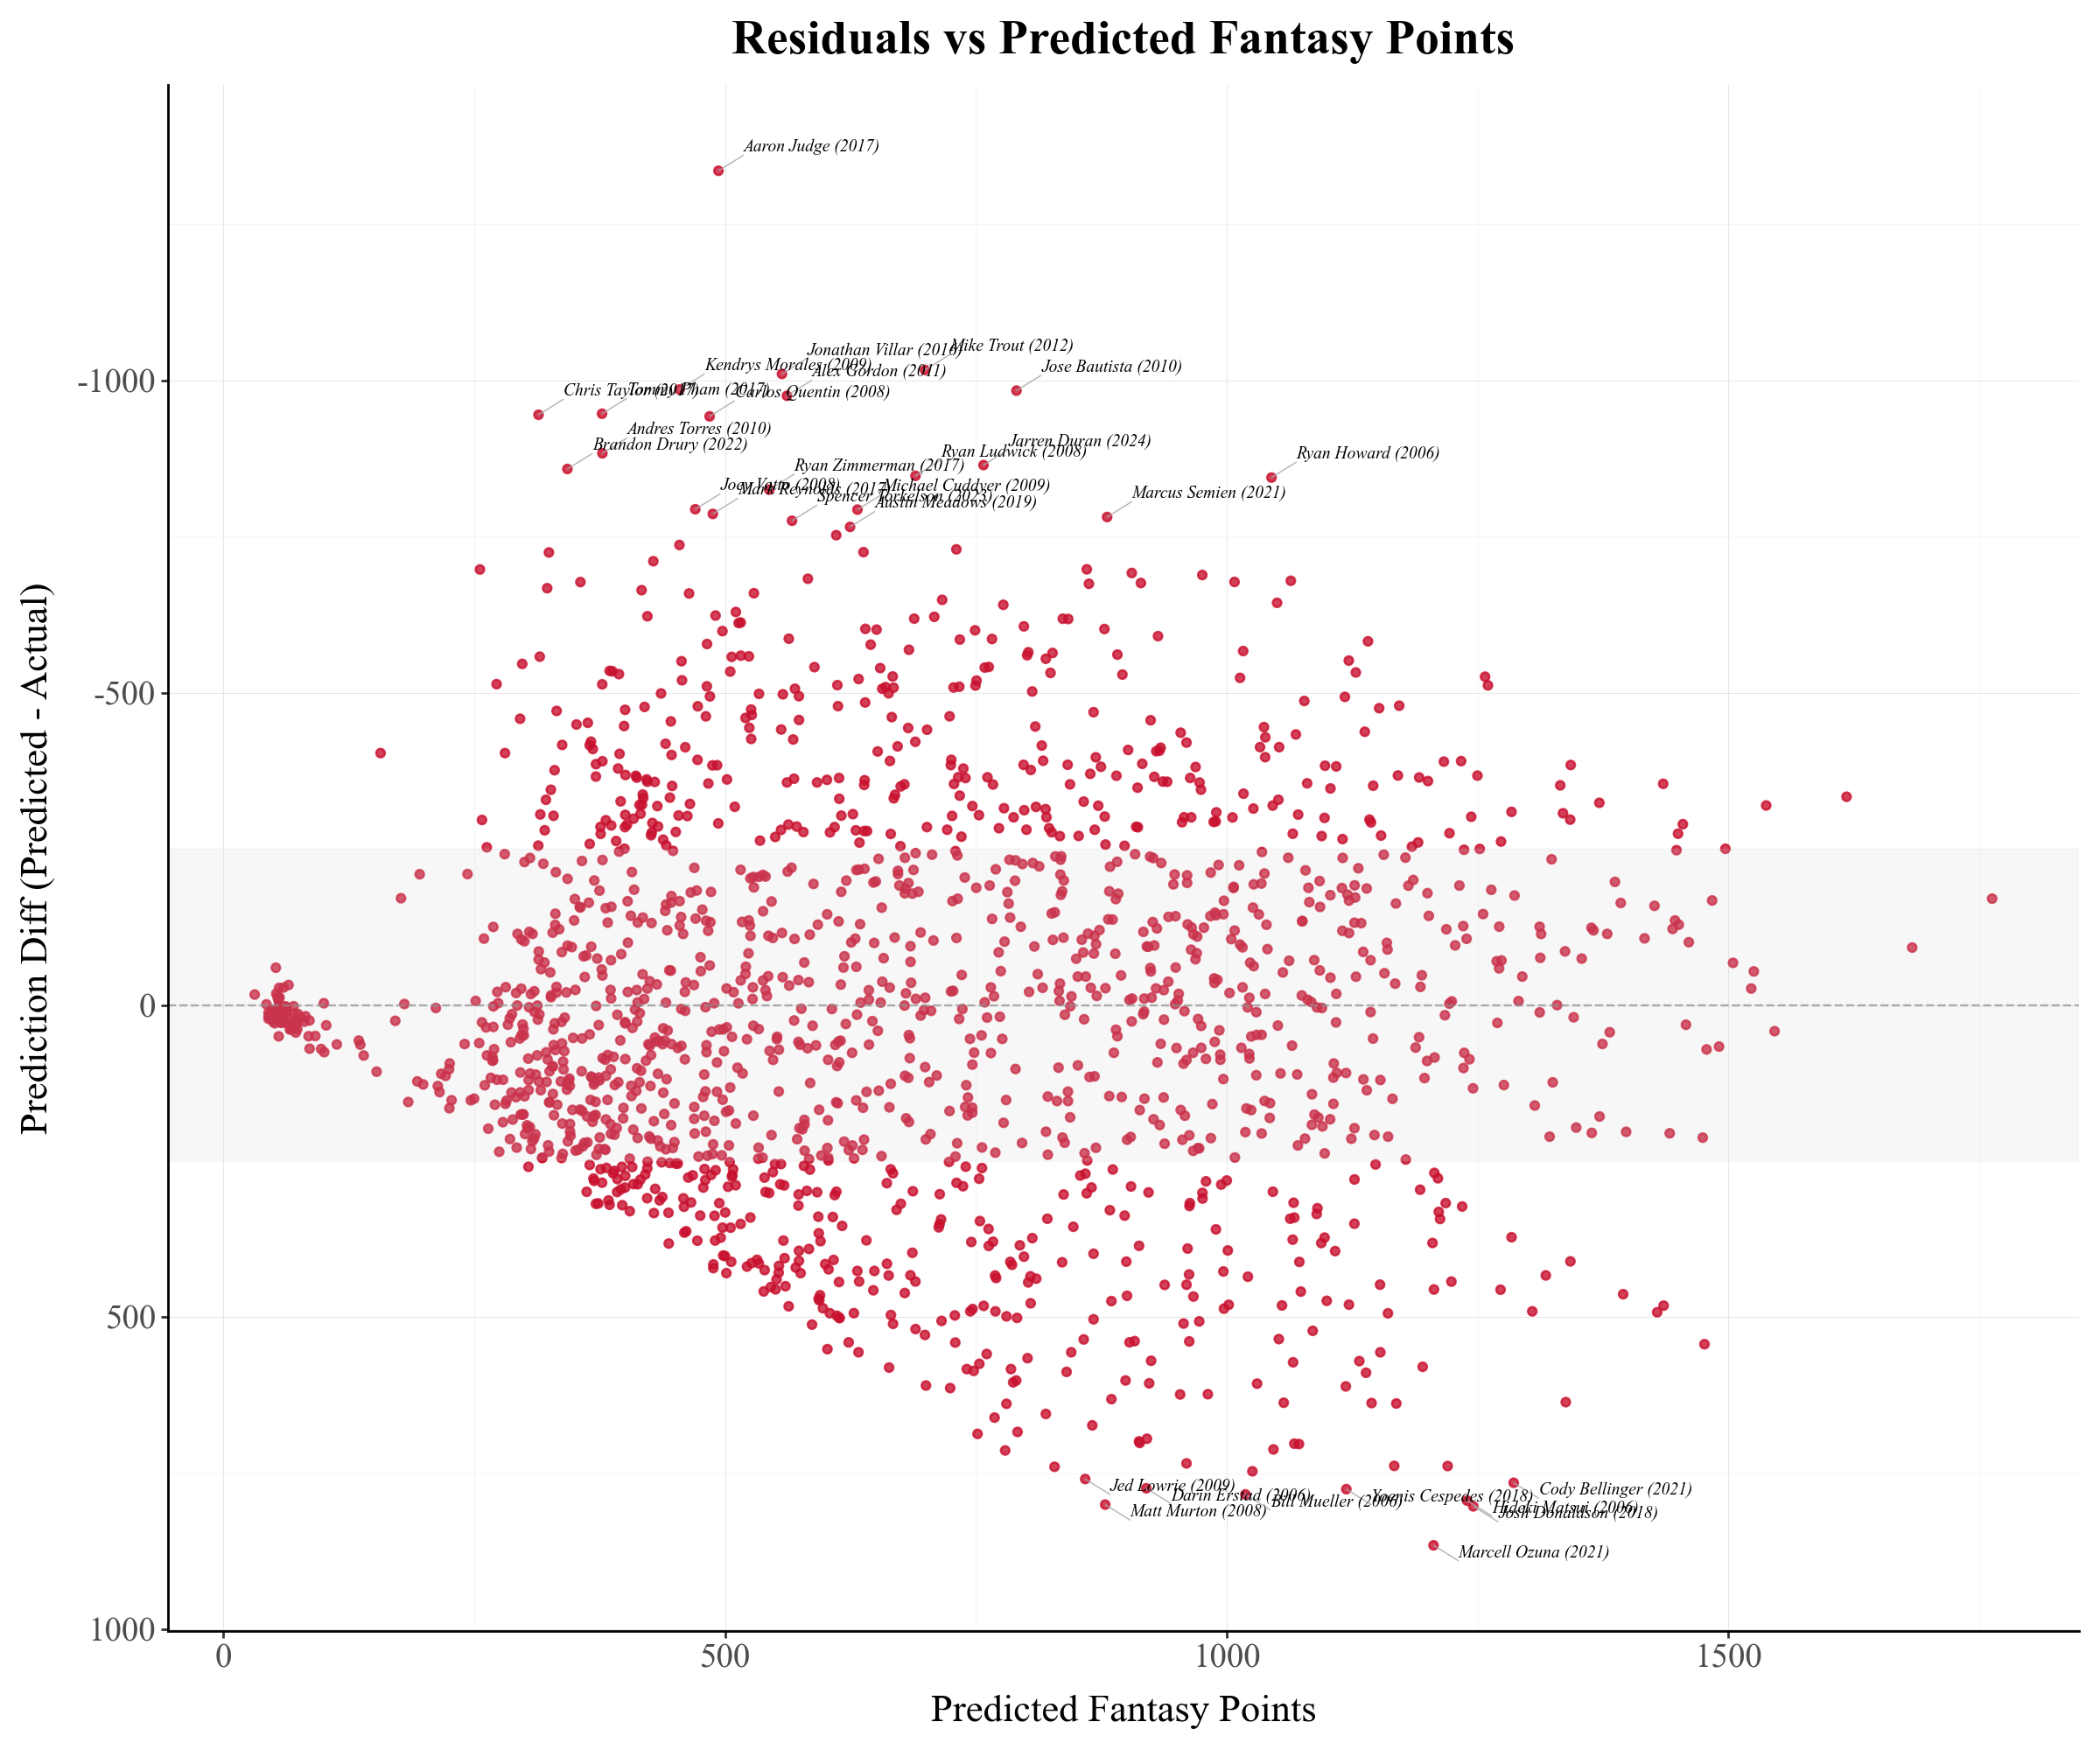

In [67]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

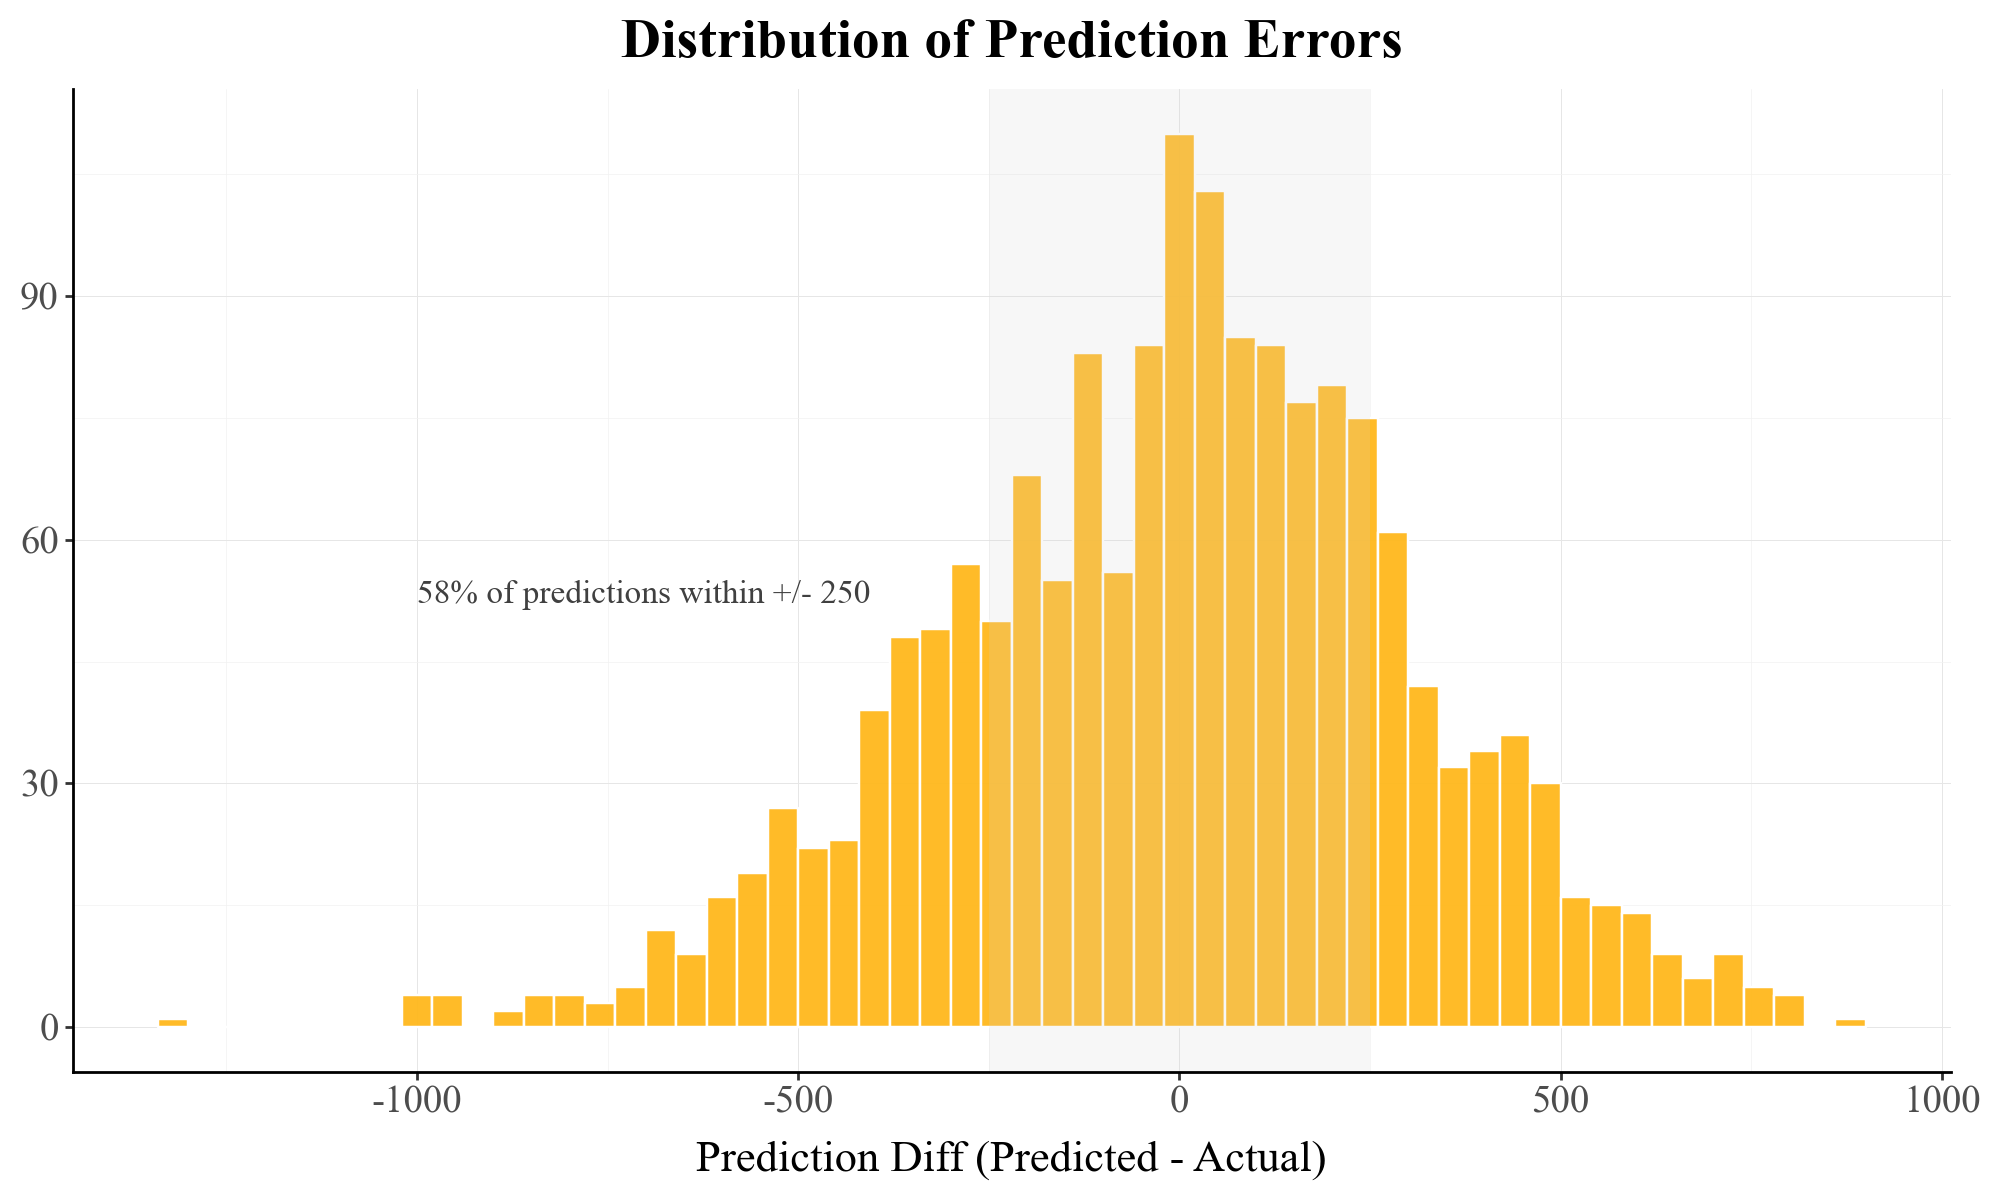

In [68]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=40,
    x_annotate=-1000,    # custom annotation position
    y_annotate=55,      # custom annotation position
)
p3.show()

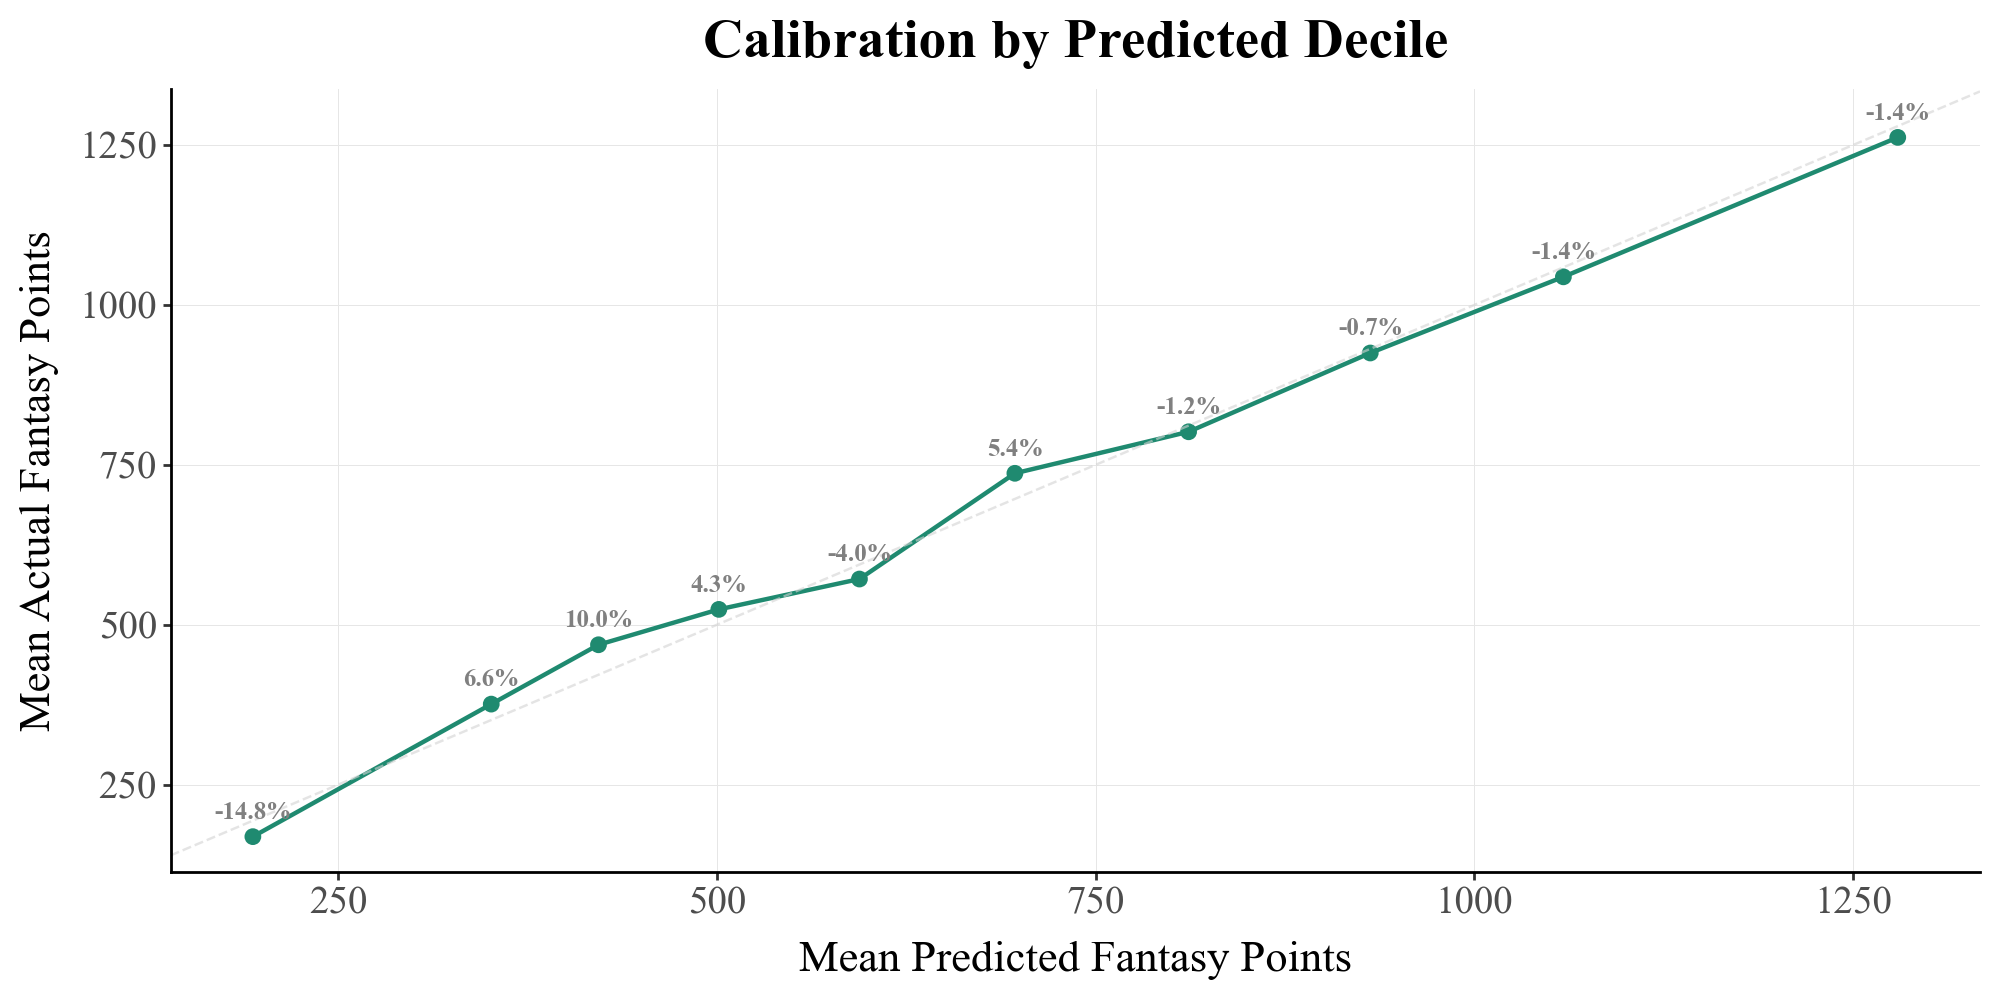

In [69]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating baseline pitching predictions

In [70]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)
# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 203.668 | MAE: 151.222 | R^2: 0.479


In [71]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
361   Justin Verlander                 1167.3               1189.757446   
313    Felix Hernandez                 1193.0               1162.791626   
470       Jered Weaver                 1200.6               1149.041016   
149          Dan Haren                 1107.0               1083.783936   
252    Felix Hernandez                 1319.6               1082.420288   
...                ...                    ...                       ...   
1410      Blake Parker                  123.0                109.203300   
51        Kevin Ginkel                   66.0                108.900230   
839      Matt Reynolds                  236.6                105.052399   
362        Tony Watson                   89.0                 86.164970   
1381      Adam Kolarek                  105.0                 84.259674   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
361         22.457446      22.457446    2009   26          1346.0  
313        -30.208374      30.208374    2011   25          1165.6  
470        -51.558984      51.558984    2010   27          1211.3  
149        -23.216064      23.216064    2009   28          1186.3  
252       -237.179712     237.179712    2009   23          1262.6  
...               ...            ...     ...  ...             ...  
1410       -13.796700      13.796700    2019   34           300.3  
51          42.900230      42.900230    2019   25           159.3  
839       -131.547601     131.547601    2010   25            98.0  
362         -2.835030       2.835030    2019   34           220.0  
1381       -20.740326      20.740326    2019   30           270.0  

[1525 rows x 8 columns]

# Pitching Predictions

In [72]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=60,
    random_state=4202020,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 60/60 [01:38<00:00,  1.65s/trial, best loss: 191.08454553207764]
Best Parameters: {'learning_rate': 0.0436297635835816, 'max_depth': 4, 'subsample': 0.8027119066117494, 'colsample_bytree': 0.7537316974714079, 'min_child_weight': 9.0970078067447, 'reg_lambda': 0.6583599490483748, 'reg_alpha': 0.07192178043900331, 'gamma': 0.023007794468850526}
[Best trial @ val] optimized=rmse | RMSE=191.085 | MAE=145.585 | ASYM=46029.377


In [73]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202020,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 189
[Val] RMSE: 191.085 | MAE: 145.585 | R^2: 0.556 | ASYM: 46029.377
[Test] RMSE: 199.748 | MAE: 148.809 | R^2: 0.498 | ASYM: 50050.199


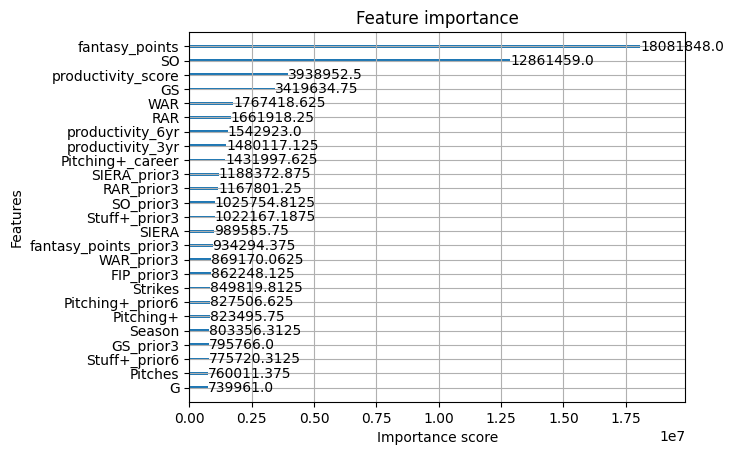

In [74]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [75]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

Name  fantasy_points_future  predicted_fantasy_points  \
313    Felix Hernandez                 1193.0               1185.685669   
361   Justin Verlander                 1167.3               1173.119873   
1300      Roy Halladay                  685.3               1113.241577   
252    Felix Hernandez                 1319.6               1110.693359   
470       Jered Weaver                 1200.6               1063.010376   
...                ...                    ...                       ...   
389        Javy Guerra                   63.6                113.668991   
1381      Adam Kolarek                  105.0                110.308517   
1063     Josh Staumont                  175.6                109.945053   
601      Yency Almonte                  138.6                108.257378   
750         Sam Howard                  127.0                102.376801   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
313         -7.314331       7.314331    2011   25          1165.6  
361          5.819873       5.819873    2009   26          1346.0  
1300       427.941577     427.941577    2011   34          1271.6  
252       -208.906641     208.906641    2009   23          1262.6  
470       -137.589624     137.589624    2010   27          1211.3  
...               ...            ...     ...  ...             ...  
389         50.068991      50.068991    2019   33           282.6  
1381         5.308517       5.308517    2019   30           270.0  
1063       -65.654947      65.654947    2019   25            78.3  
601        -30.342622      30.342622    2019   25           126.0  
750        -24.623199      24.623199    2019   26            94.0  

[1525 rows x 8 columns]

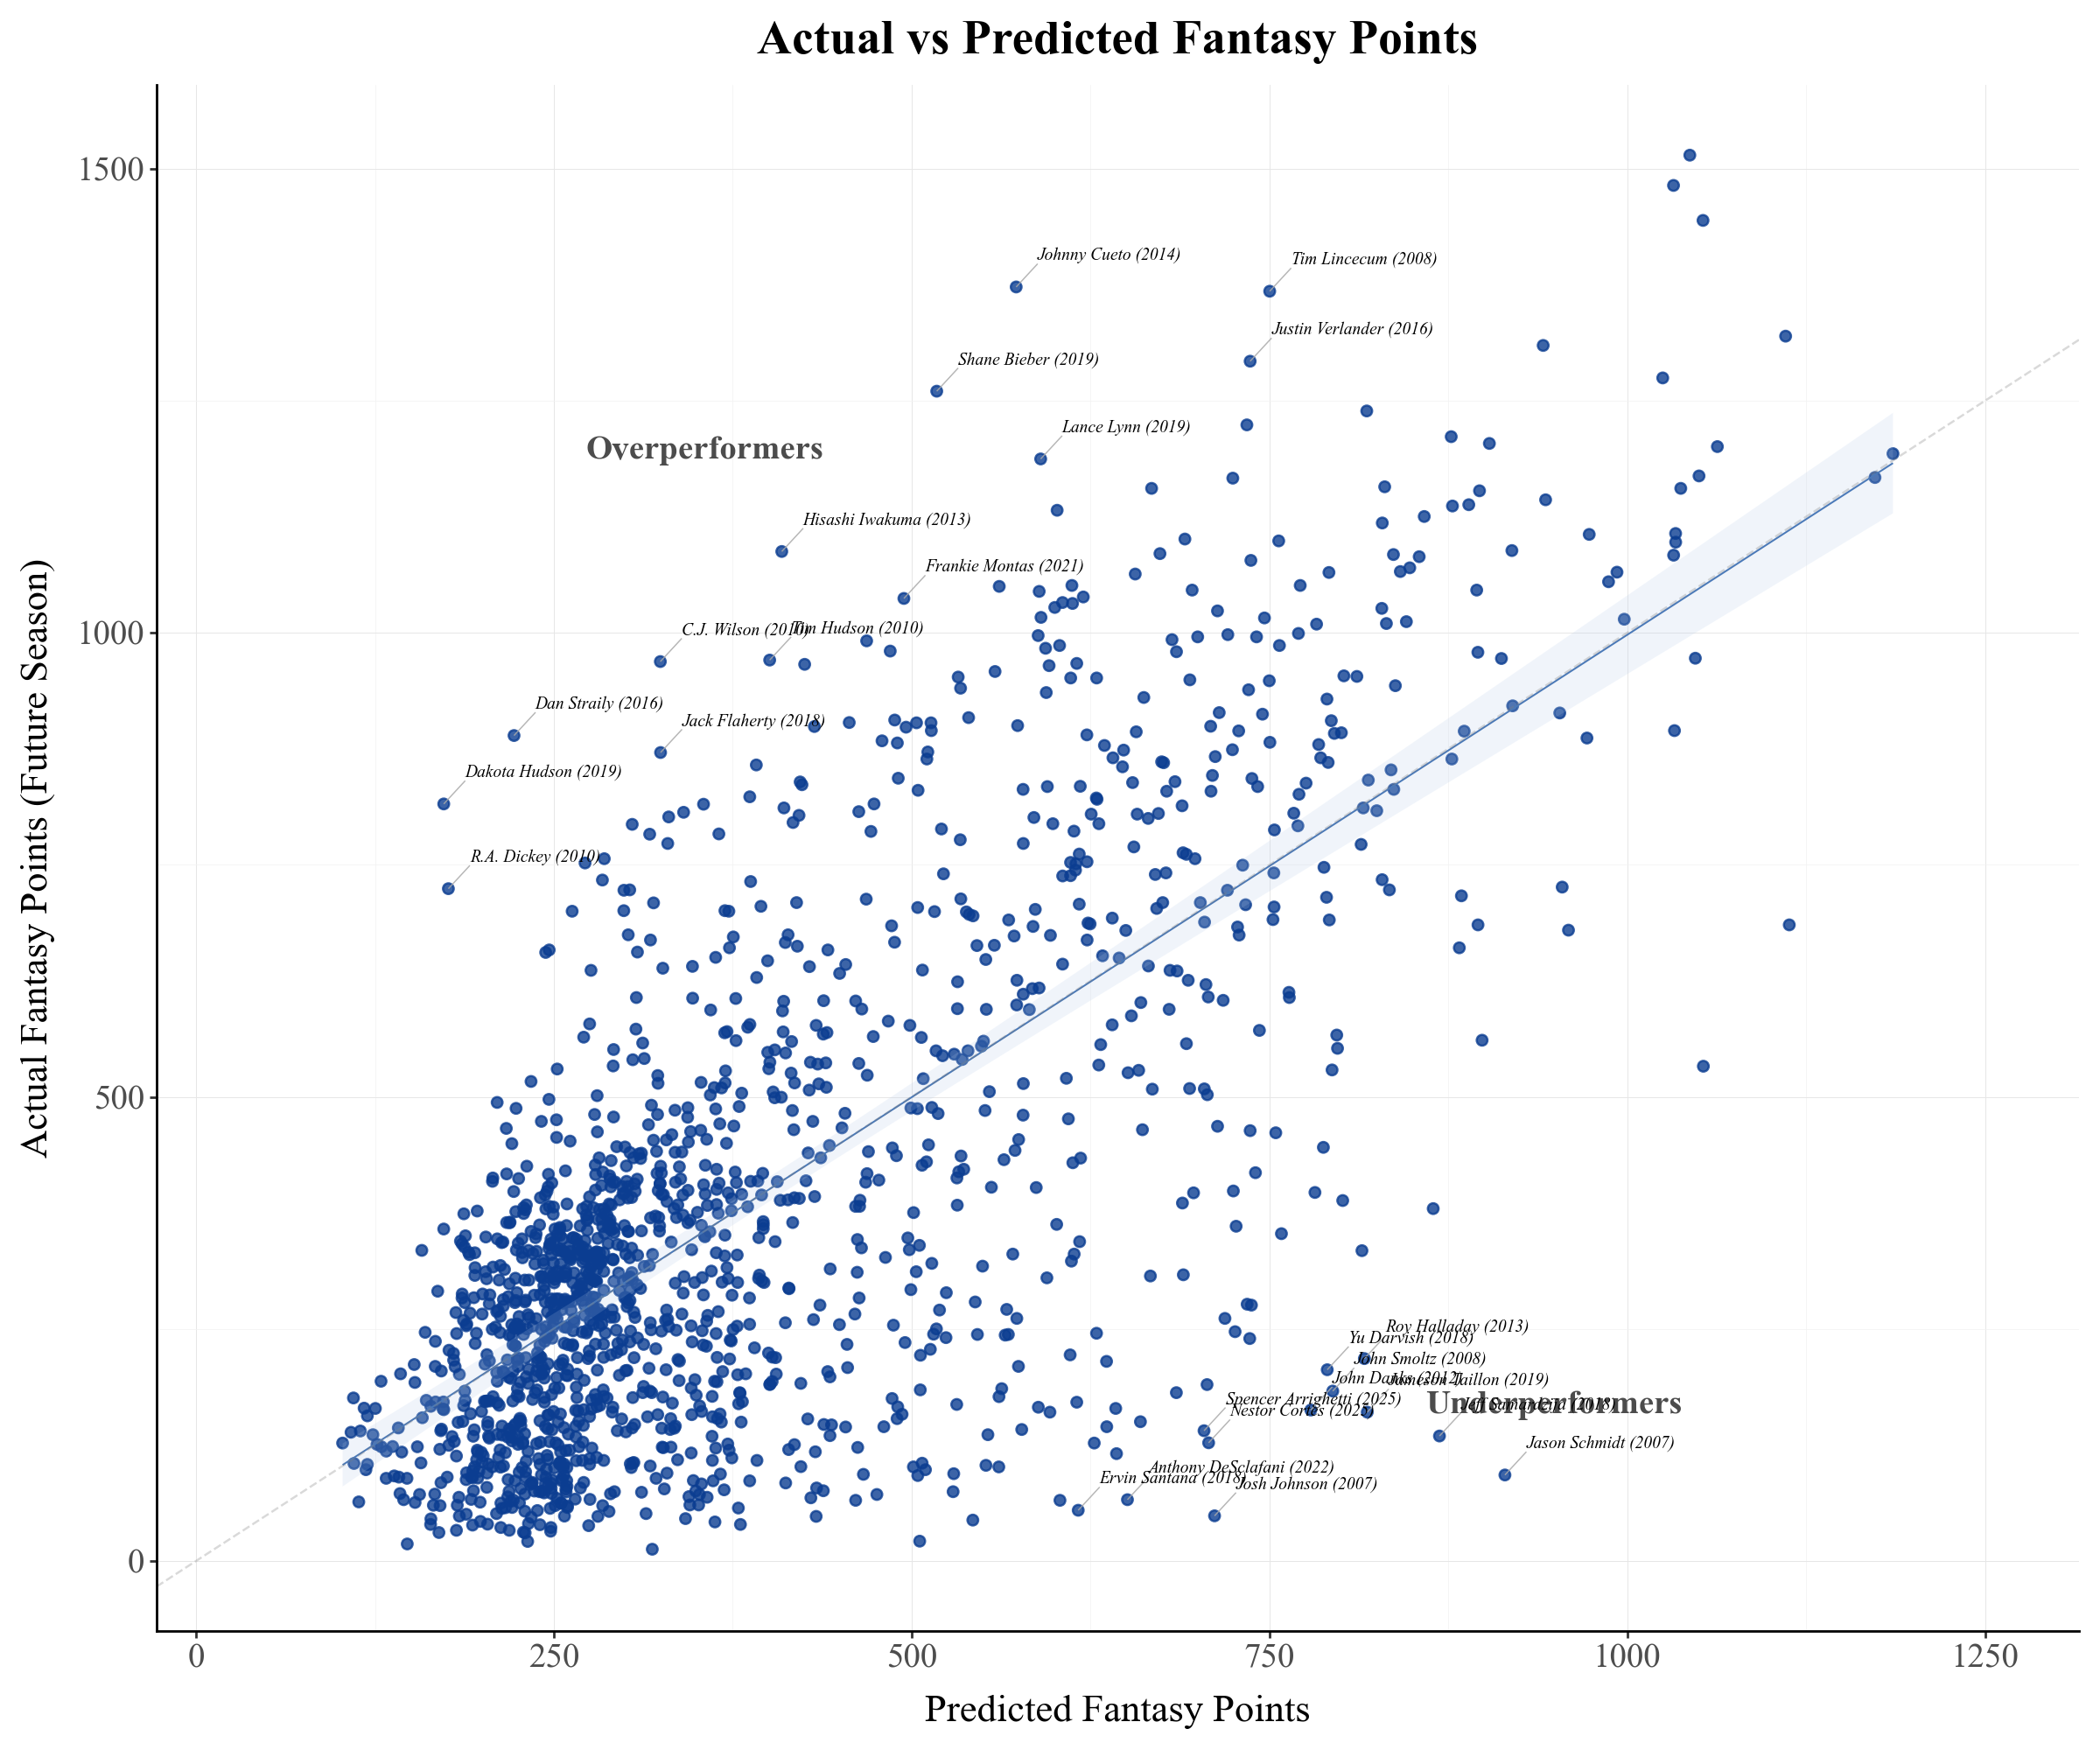

In [76]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

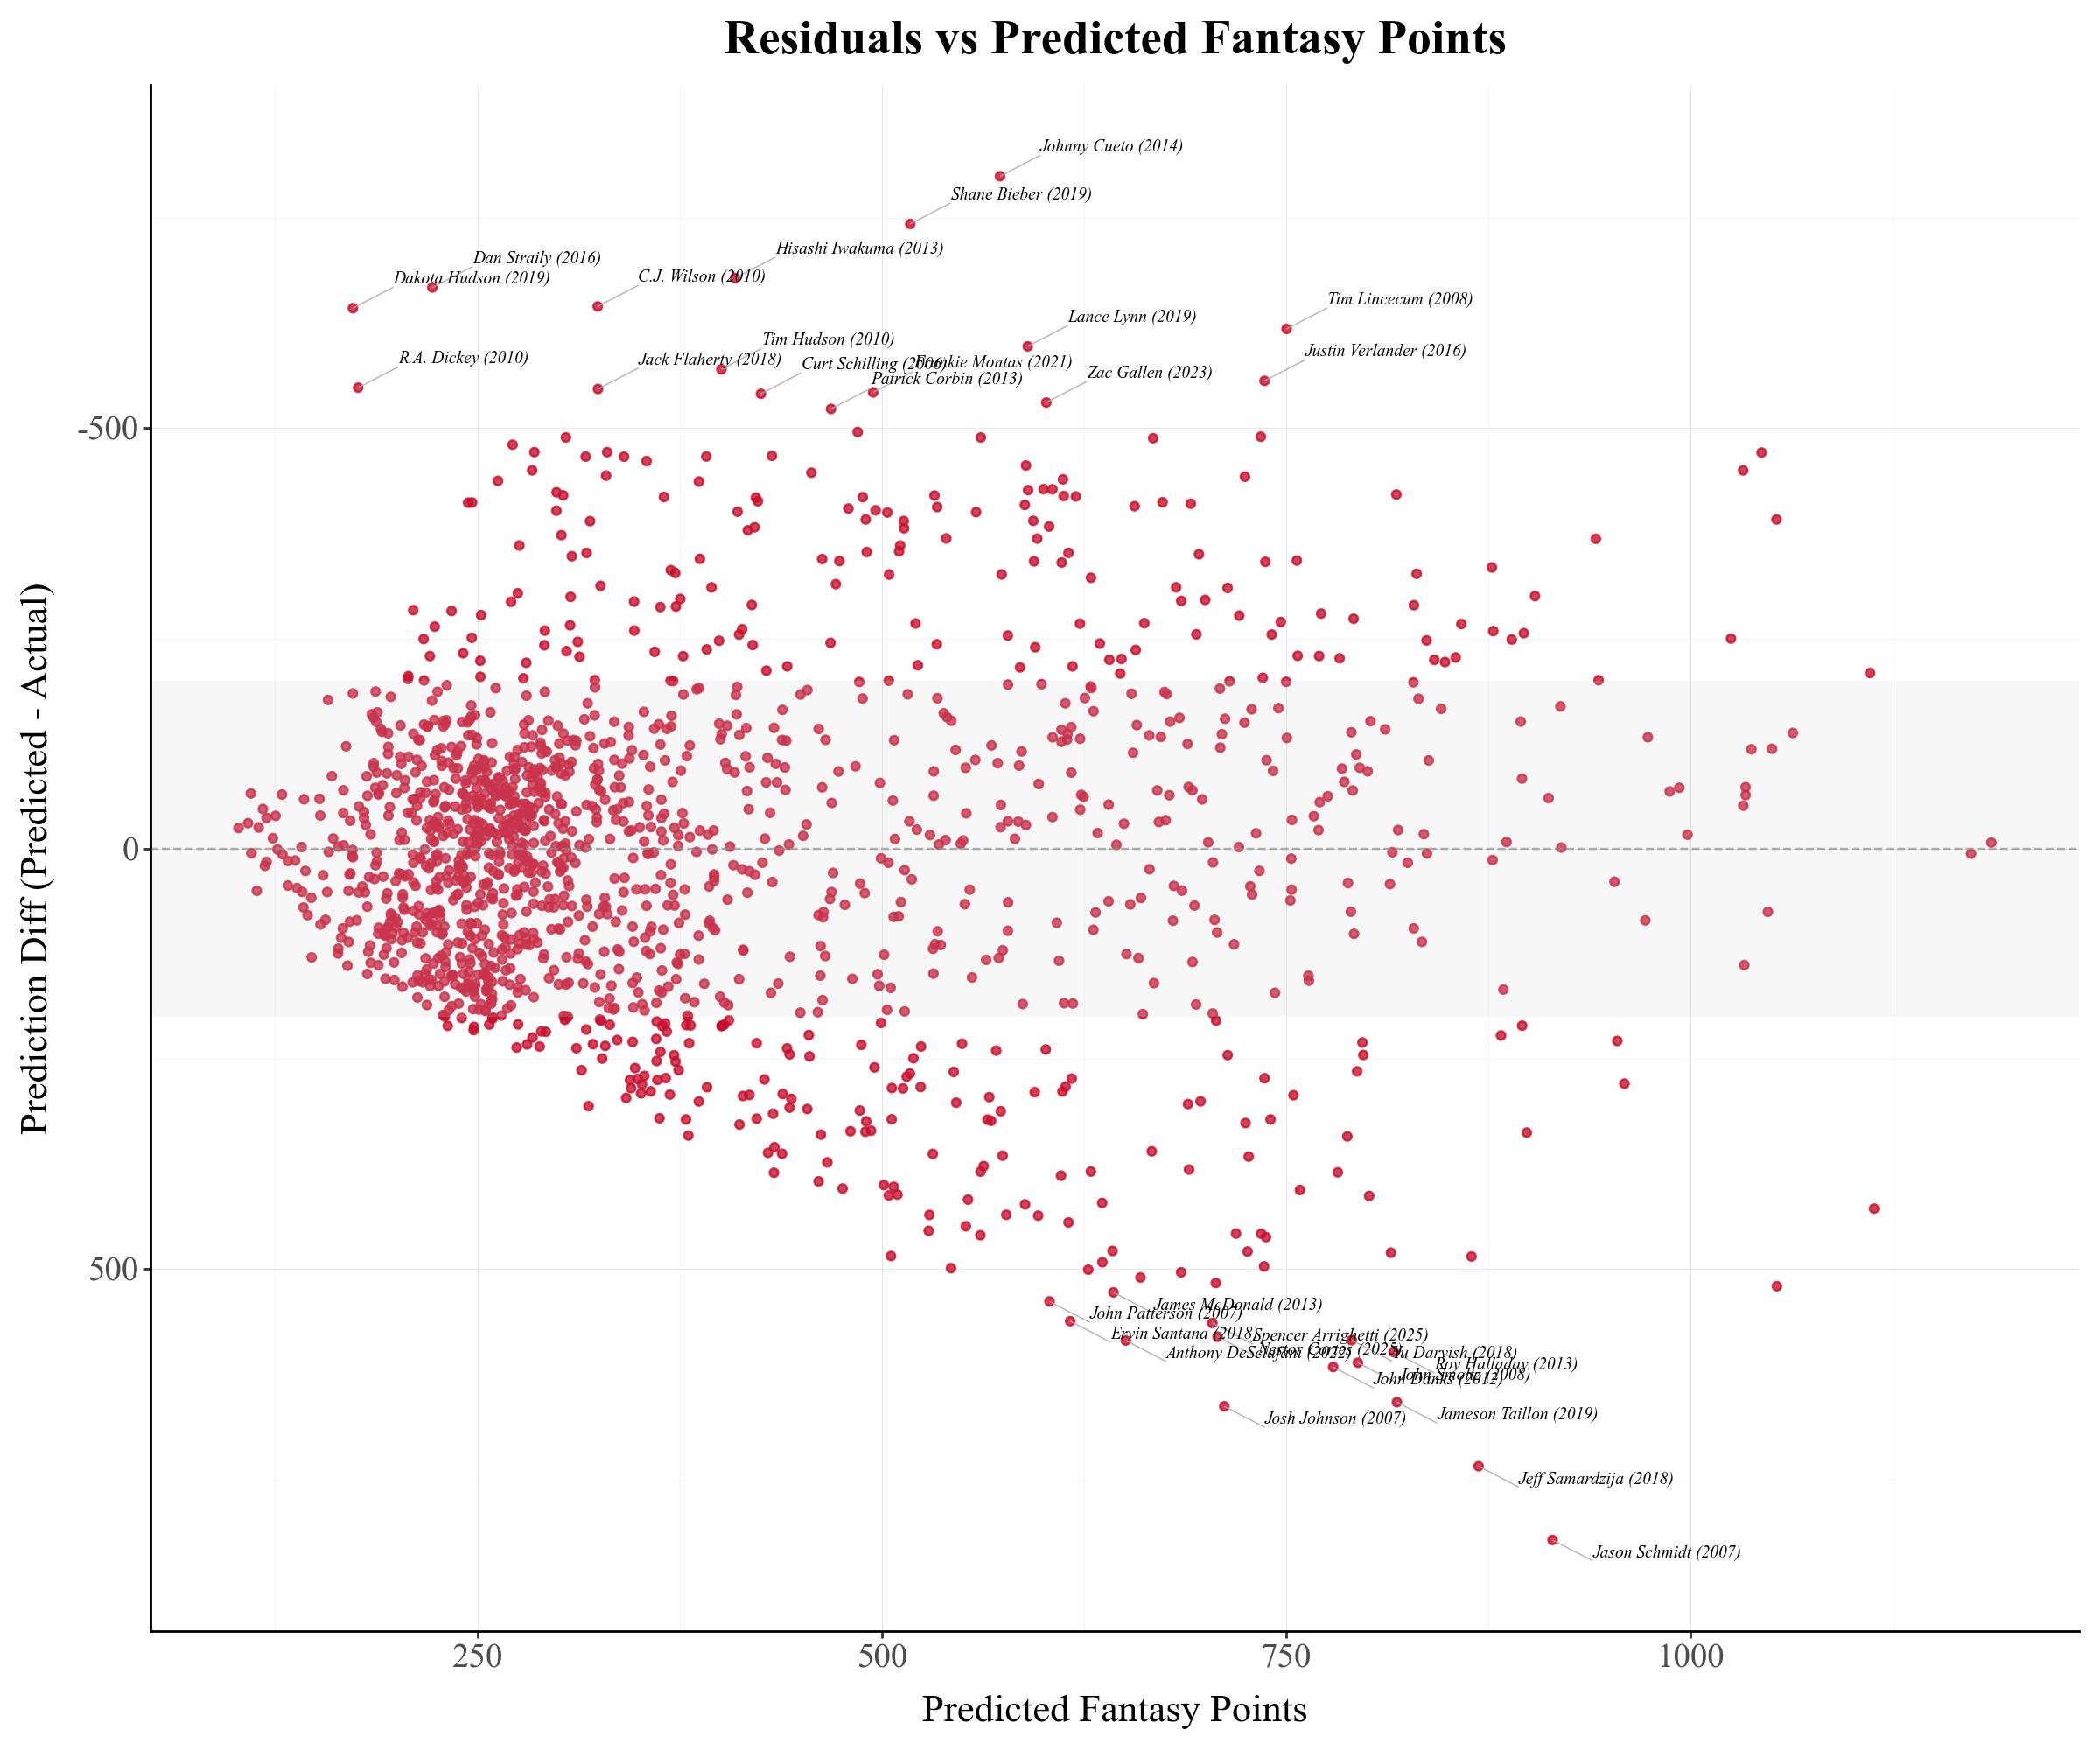

In [77]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=200,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

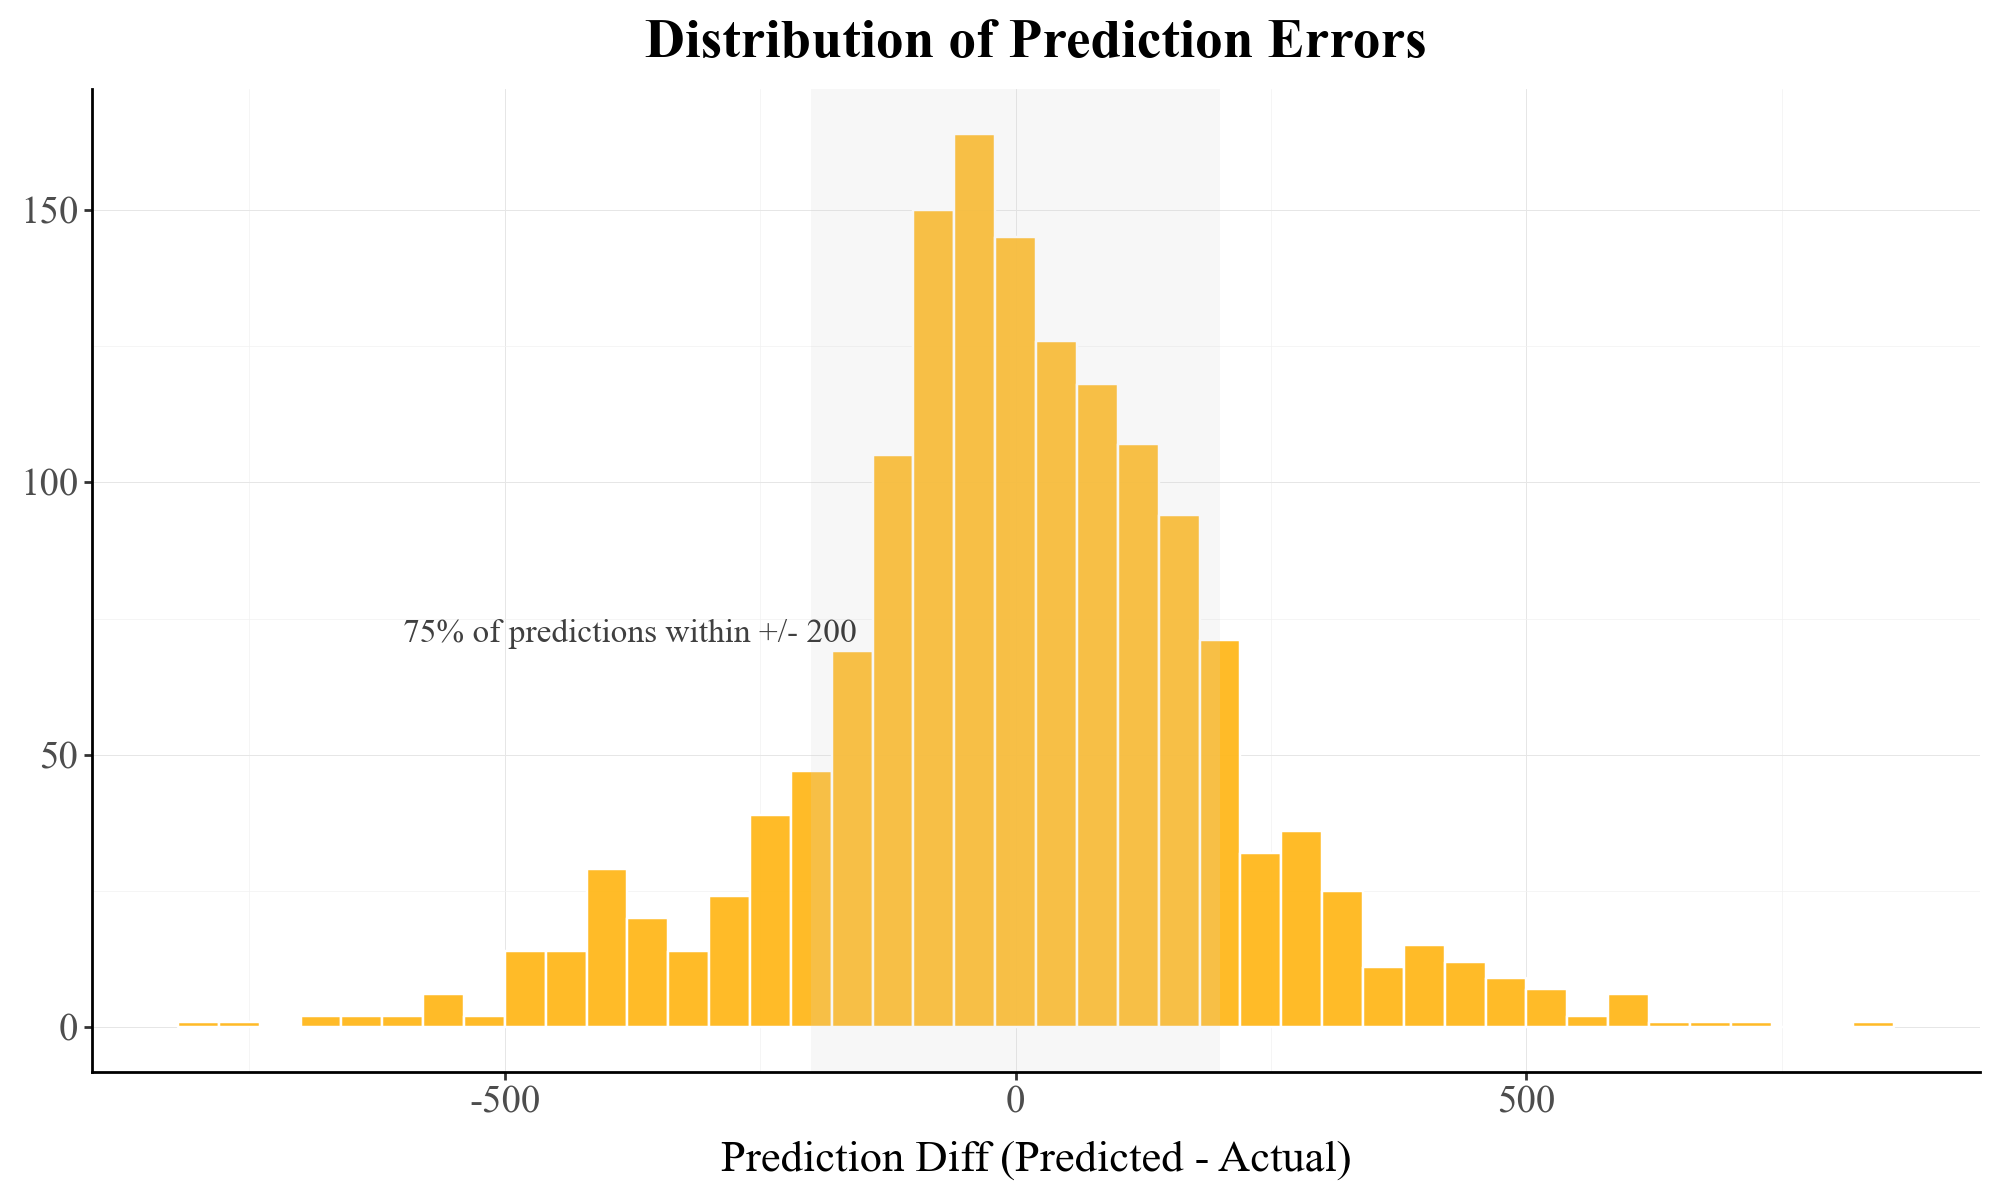

In [78]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=200,
    binwidth=40,
    x_annotate=-600,    # custom annotation position
    y_annotate=75,      # custom annotation position
)
p3.show()

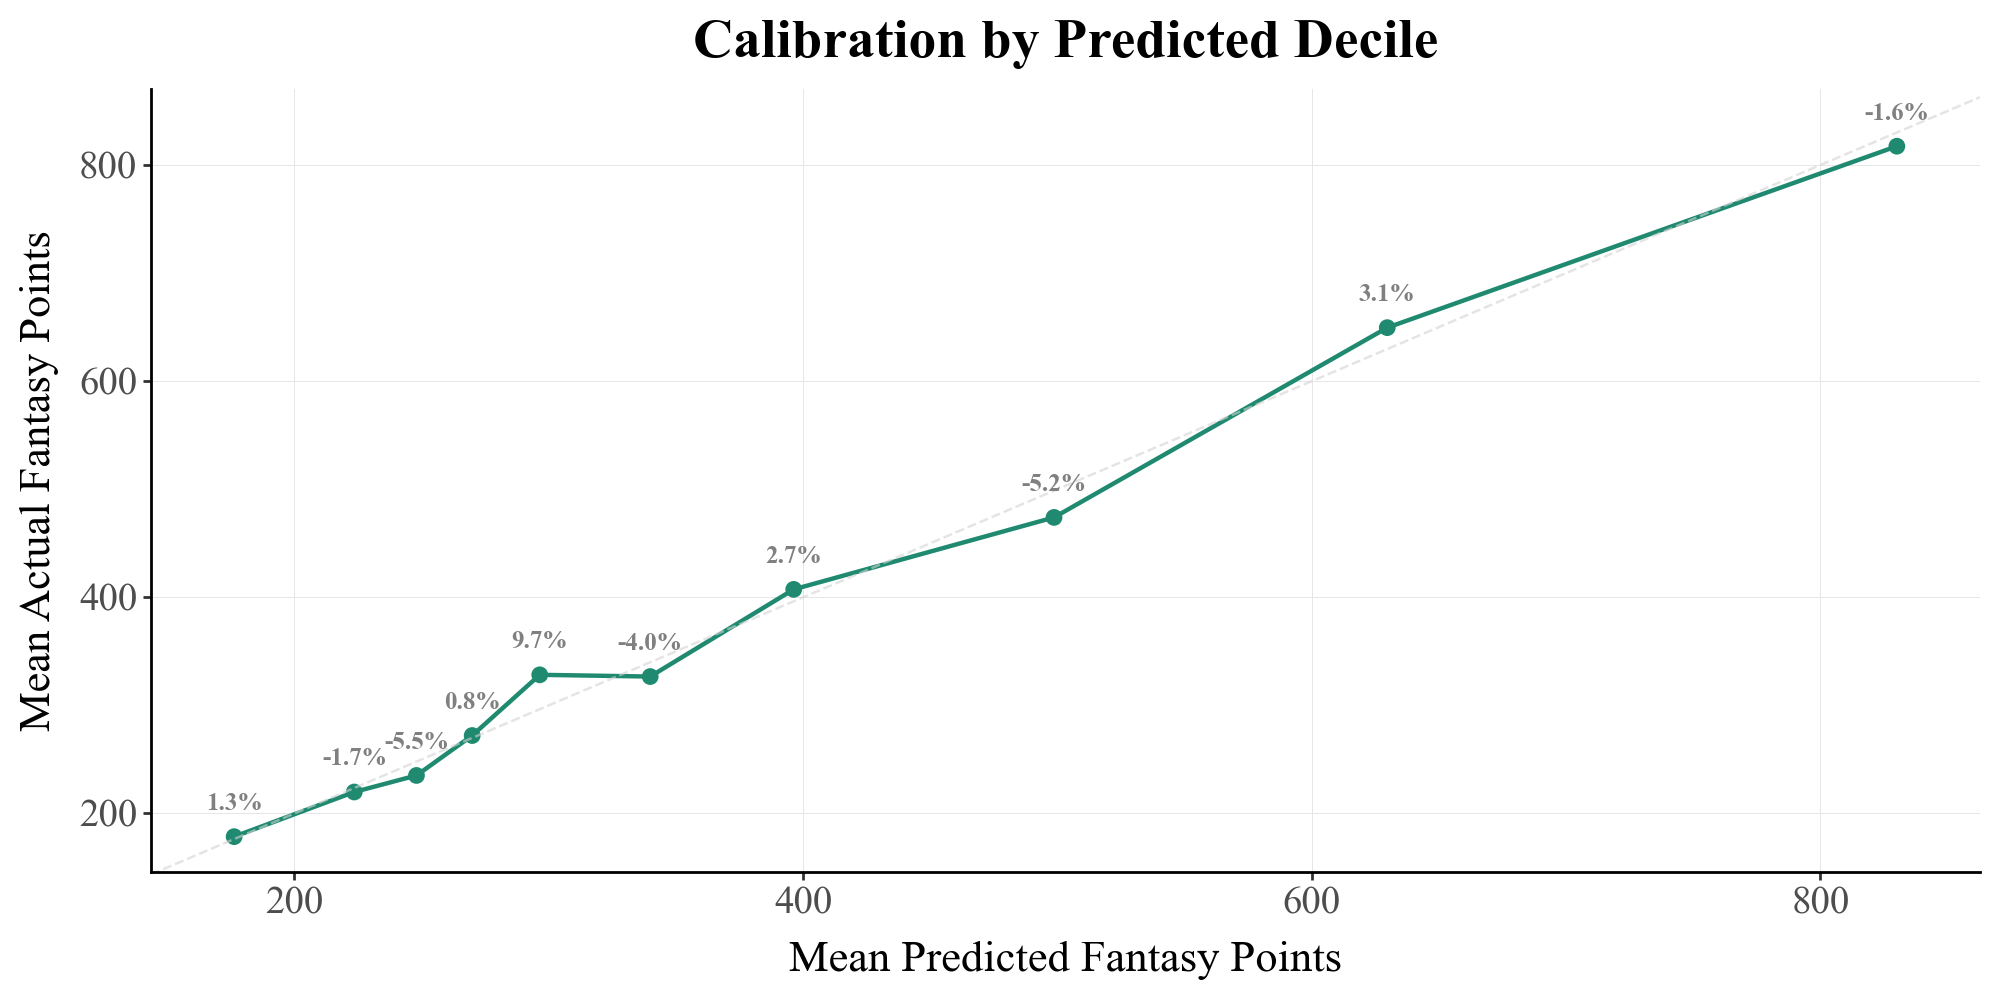

In [79]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [80]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_predictions = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_predictions = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

In [81]:
batting_pred['fantasy_points_pred'] = batting_predictions
pitching_pred['fantasy_points_pred'] = pitching_predictions

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [82]:
display(batting_pred)

IDfg  Season              Name  Age    G   AB    H   1B  2B  3B  ...  \
10491  20123    2025         Juan Soto   26  160  577  152   88  20   1  ...   
10328  19755    2025     Shohei Ohtani   30  158  611  172   83  25   9  ...   
9180   15640    2025       Aaron Judge   33  152  541  179   94  30   2  ...   
10089  19251    2025       Pete Alonso   30  162  624  170   90  41   1  ...   
8456   13510    2025      Jose Ramirez   32  158  593  168  101  34   3  ...   
...      ...     ...               ...  ...  ...  ...  ...  ...  ..  ..  ...   
5694    6887    2025  Martin Maldonado   38   64  147   30   20   6   0  ...   
10851  23296    2025       Jacob Amaya   26   37   66    7    6   1   0  ...   
10109  19262    2025   Garrett Hampson   30   62   77   11    9   2   0  ...   
8555   13723    2025   Jacob Stallings   35   43  119   16   12   4   0  ...   
9036   15172    2025      Tim Anderson   32   31   83   17   14   3   0  ...   

       is_intl_undrafted  fantasy_points_delta  productivity_score  \
10491                  1             51.000000            2.683432   
10328                  1             29.333333            2.147778   
9180                   0            220.000000            1.791552   
10089                  0             92.666667            1.735556   
8456                   1              4.333333            1.567383   
...                  ...                   ...                 ...   
5694                   0           -108.333333            0.142659   
10851                  0             19.000000            0.105030   
10109                  0           -175.333333            0.137778   
8555                   0           -232.666667            0.093878   
9036                   0           -255.000000            0.101562   

       productivity_trend  productivity_3yr  productivity_6yr    era  \
10491           -0.194968          2.823851          2.642851  2020s   
10328           -0.400379          2.260465          1.970738  2020s   
9180            -0.217237          1.677810          1.554022  2020s   
10089            0.085139          1.748555          1.702107  2020s   
8456            -0.214095          1.666287          1.645090  2020s   
...                   ...               ...               ...    ...   
5694             0.031629          0.235026          0.335239  2020s   
10851           -0.005370          0.107715          0.107715  2020s   
10109           -0.248667          0.365642          0.566978  2020s   
8555            -0.384496          0.305535          0.408843  2020s   
9036            -0.154421          0.388441          0.680428  2020s   

       years_covered_prior3  years_covered_prior6  fantasy_points_pred  
10491                     3                     6          1643.318848  
10328                     3                     6          1622.146362  
9180                      3                     6          1557.913574  
10089                     3                     6          1469.602783  
8456                      3                     6          1458.360107  
...                     ...                   ...                  ...  
5694                      3                     6           219.383163  
10851                     3                     3           209.990555  
10109                     3                     6           203.448288  
8555                      3                     6           198.520721  
9036                      3                     6           163.462326  

[537 rows x 204 columns]

In [83]:
display(pitching_pred)

IDfg  Season              Name  Age   G  GS  Pitches  Strikes   W  \
9510   17995    2025        Logan Webb   28  34  34     3282     2165  15   
10615  22267    2025      Tarik Skubal   28  31  31     2849     2003  13   
6616   10310    2025      Zack Wheeler   35  24  24     2394     1549  10   
11004  27463    2025   Garrett Crochet   26  32  32     3151     2114  18   
10907  25880    2025      Hunter Brown   26  31  31     2964     1832  12   
...      ...     ...               ...  ...  ..  ..      ...      ...  ..   
11020  27477    2025      Bryce Jarvis   27  12   0      409      242   0   
10943  26203    2025  Andrew Saalfrank   27  28   0      427      271   2   
2805    3237    2025    T.J. McFarland   36  27   0      272      175   0   
10767  24203    2025      Luis Peralta   24  22   0      436      250   1   
11226  31552    2025        Zach Agnos   24  30   0      527      309   1   

       WAR  ...  is_intl_undrafted  fantasy_points_delta  productivity_score  \
9510   5.5  ...                  0             94.800000            1.461735   
10615  6.6  ...                  0            251.766667            1.567985   
6616   4.0  ...                  0           -110.600000            0.773551   
11004  5.8  ...                  0            535.300000            1.913166   
10907  4.6  ...                  0            156.633333            1.602515   
...    ...  ...                ...                   ...                 ...   
11020  0.0  ...                  0            -51.000000            0.119342   
10943  0.5  ...                  0             81.566667            0.194787   
2805  -0.1  ...                  0            -57.733333            0.023611   
10767 -0.7  ...                  0              8.233333            0.086806   
11226 -0.4  ...                  0             57.533333            0.149826   

       productivity_trend  productivity_3yr  productivity_6yr    era  \
9510             0.149526          1.442892          1.282297  2020s   
10615           -0.073991          1.319641          1.088465  2020s   
6616            -0.248075          0.918564          0.876909  2020s   
11004            0.439566          1.350203          1.350203  2020s   
10907            0.156115          1.473828          1.166950  2020s   
...                   ...               ...               ...    ...   
11020           -0.225777          0.203673          0.203673  2020s   
10943            0.000000          0.194787          0.194787  2020s   
2805            -0.158920          0.090936          0.117871  2020s   
10767            0.000000          0.086806          0.086806  2020s   
11226            0.000000          0.149826          0.149826  2020s   

       years_covered_prior3  years_covered_prior6  fantasy_points_pred  
9510                      3                     6           984.941406  
10615                     3                     6           959.052124  
6616                      3                     6           945.404785  
11004                     3                     6           902.613647  
10907                     3                     4           898.195923  
...                     ...                   ...                  ...  
11020                     3                     3           149.737503  
10943                     3                     3           144.514847  
2805                      3                     6           144.478729  
10767                     1                     1           141.989395  
11226                     1                     1           120.183342  

[590 rows x 191 columns]

In [84]:
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

In [85]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


IDfg  Season       Name   Age      G     AB     H    1B    2B   3B  \
450  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
451  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
452  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   
453  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   

     ...  productivity_6yr    era  years_covered_prior3  years_covered_prior6  \
450  ...          0.968389  2020s                     3                     6   
451  ...          0.968389  2020s                     3                     6   
452  ...          0.700413  2020s                     1                     1   
453  ...          0.700413  2020s                     1                     1   

     fantasy_points_pred  first_name  last_name  Team  Positions  \
450           708.588745         max      muncy   LAD         3B   
451           708.588745         max      muncy   ATH   2B,3B,SS   
452           493.929352         max      muncy   LAD         3B   
453           493.929352         max      muncy   ATH   2B,3B,SS   

     projected_fantasy_points  
450                     899.0  
451                     649.0  
452                     899.0  
453                     649.0  

[4 rows x 209 columns]

In [86]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

IDfg  Season            Name   Age      G     AB      H    1B    2B  \
0        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
1    15640.0  2025.0     Aaron Judge  33.0  152.0  541.0  179.0  94.0  30.0   
2        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
3    19844.0  2025.0    Abraham Toro  28.0   77.0  259.0   62.0  42.0  13.0   
4    27962.0  2025.0    Adael Amador  22.0   41.0  113.0   20.0  12.0   7.0   
..       ...     ...             ...   ...    ...    ...    ...   ...   ...   
684  31562.0  2025.0    Zach Dezenzo  25.0   34.0   98.0   24.0  16.0   6.0   
685  19392.0  2025.0  Zach McKinstry  30.0  144.0  452.0  117.0  71.0  23.0   
686  31347.0  2025.0       Zach Neto  24.0  128.0  502.0  129.0  73.0  29.0   
687  29766.0  2025.0      Zack Gelof  25.0   30.0   92.0   16.0  11.0   3.0   
688  19562.0  2025.0      Zack Short  30.0   22.0   50.0   11.0   7.0   2.0   

       3B  ...  productivity_6yr    era  years_covered_prior3  \
0     NaN  ...               NaN    NaN                  <NA>   
1     2.0  ...          1.554022  2020s                     3   
2     NaN  ...               NaN    NaN                  <NA>   
3     0.0  ...          0.657902  2020s                     3   
4     0.0  ...          0.326446  2020s                     1   
..    ...  ...               ...    ...                   ...   
684   0.0  ...          0.242806  2020s                     1   
685  11.0  ...          0.756760  2020s                     3   
686   1.0  ...          1.880020  2020s                     3   
687   0.0  ...          1.039738  2020s                     3   
688   0.0  ...          0.298152  2020s                     3   

     years_covered_prior6  fantasy_points_pred  first_name  last_name  Team  \
0                    <NA>                  NaN        a.j.   vukovich   ARI   
1                       6          1557.913574       aaron      judge   NYY   
2                    <NA>                  NaN    abimelec      ortiz   TEX   
3                       6           456.553894     abraham       toro   NaN   
4                       1           372.608978       adael     amador   COL   
..                    ...                  ...         ...        ...   ...   
684                     1           421.381531        zach    dezenzo   HOU   
685                     6           751.531494        zach  mckinstry   DET   
686                     3          1172.499023        zach       neto   LAA   
687                     3           437.322144        zack      gelof   ATH   
688                     5           377.486420        zack      short   NaN   

       Positions  projected_fantasy_points  
0       3B,LF,CF                      64.0  
1    LF,CF,RF,DH                    1721.0  
2             1B                     104.0  
3            NaN                       NaN  
4             2B                     650.0  
..           ...                       ...  
684     1B,LF,RF                     173.0  
685  3B,SS,LF,RF                     734.0  
686           SS                    1306.0  
687           2B                     223.0  
688          NaN                       NaN  

[687 rows x 209 columns]

In [87]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

No duplicate rows found.


In [36]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

IDfg  Season            Name   Age     G    GS  Pitches  Strikes  \
0    31764.0  2025.0   A.J. Blubaugh  24.0  11.0   3.0    508.0    316.0   
1        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
2        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
3        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
4    23550.0  2025.0     Aaron Ashby  27.0  43.0   1.0   1033.0    645.0   
..       ...     ...             ...   ...   ...   ...      ...      ...   
896  20349.0  2025.0      Zack Kelly  30.0  28.0   0.0    583.0    383.0   
897  15823.0  2025.0    Zack Littell  29.0  32.0  32.0   2789.0   1868.0   
898  10310.0  2025.0    Zack Wheeler  35.0  24.0  24.0   2394.0   1549.0   
899  25703.0  2025.0        Zak Kent  27.0  12.0   0.0    308.0    187.0   
900  31827.0  2025.0  Zebby Matthews  25.0  16.0  16.0   1353.0    895.0   

        W  WAR  ...  productivity_6yr    era  years_covered_prior3  \
0     3.0  0.1  ...          0.343750  2020s                     1   
1     NaN  NaN  ...               NaN    NaN                  <NA>   
2     NaN  NaN  ...               NaN    NaN                  <NA>   
3     NaN  NaN  ...               NaN    NaN                  <NA>   
4     5.0  1.2  ...          0.520839  2020s                     3   
..    ...  ...  ...               ...    ...                   ...   
896   1.0  0.4  ...          0.271894  2020s                     3   
897  10.0  1.5  ...          0.596162  2020s                     3   
898  10.0  4.0  ...          0.876909  2020s                     3   
899   1.0  0.1  ...          0.106447  2020s                     1   
900   5.0  1.4  ...          0.443718  2020s                     2   

     years_covered_prior6  fantasy_points_pred  first_name  last_name  Team  \
0                       1           380.817719        a.j.   blubaugh   NaN   
1                    <NA>                  NaN        a.j.     causey    KC   
2                    <NA>                  NaN        a.j.     minter   NYM   
3                    <NA>                  NaN        a.j.        puk   ARI   
4                       5           345.159607       aaron      ashby   MIL   
..                    ...                  ...         ...        ...   ...   
896                     4           254.601181        zack      kelly   BOS   
897                     6           505.666290        zack    littell   NaN   
898                     6           923.223267        zack    wheeler   PHI   
899                     1           236.736511         zak       kent   TEX   
900                     2           536.663879       zebby   matthews   MIN   

     Positions  projected_fantasy_points  
0          NaN                       NaN  
1            P                      83.0  
2           RP                     294.3  
3           RP                     159.1  
4           RP                     300.6  
..         ...                       ...  
896      SP,RP                     241.2  
897         SP                     709.4  
898         SP                     723.9  
899      SP,RP                      67.4  
900         SP                     585.5  

[901 rows x 196 columns]

In [88]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [89]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [90]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [199]:
# def get_value_before_comma(value):
#     if ',' in value:
#         return value.split(',')[0]
#     return value

# # Apply the function to the column
# batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

In [91]:
# Display the DataFrame to verify the changes
display(batting_final)

IDfg            Name   Age Team Position  fantasy_points_pred  \
0        NaN   A.j. Vukovich   NaN  ARI       3B                  NaN   
1    15640.0     Aaron Judge  33.0  NYY       OF          1557.913574   
2        NaN  Abimelec Ortiz   NaN  TEX       1B                  NaN   
3    19844.0    Abraham Toro  28.0  NaN       DH           456.553894   
4    27962.0    Adael Amador  22.0  COL       2B           372.608978   
..       ...             ...   ...  ...      ...                  ...   
684  31562.0    Zach Dezenzo  25.0  HOU       1B           421.381531   
685  19392.0  Zach McKinstry  30.0  DET       3B           751.531494   
686  31347.0       Zach Neto  24.0  LAA       SS          1172.499023   
687  29766.0      Zack Gelof  25.0  ATH       2B           437.322144   
688  19562.0      Zack Short  30.0  NaN       DH           377.486420   

     projected_fantasy_points  
0                        64.0  
1                      1721.0  
2                       104.0  
3                         NaN  
4                       650.0  
..                        ...  
684                     173.0  
685                     734.0  
686                    1306.0  
687                     223.0  
688                       NaN  

[687 rows x 7 columns]

In [42]:
# Display the DataFrame to verify the changes
display(pitching_final)

IDfg            Name   Age Team Position  fantasy_points_pred  \
0    31764.0   A.J. Blubaugh  24.0  NaN       SP           380.817719   
1        NaN     A.j. Causey   NaN   KC        P                  NaN   
2        NaN     A.j. Minter   NaN  NYM       RP                  NaN   
3        NaN        A.j. Puk   NaN  ARI       RP                  NaN   
4    23550.0     Aaron Ashby  27.0  MIL       RP           345.159607   
..       ...             ...   ...  ...      ...                  ...   
896  20349.0      Zack Kelly  30.0  BOS       SP           254.601181   
897  15823.0    Zack Littell  29.0  NaN       SP           505.666290   
898  10310.0    Zack Wheeler  35.0  PHI       SP           923.223267   
899  25703.0        Zak Kent  27.0  TEX       SP           236.736511   
900  31827.0  Zebby Matthews  25.0  MIN       SP           536.663879   

     projected_fantasy_points  
0                         NaN  
1                        83.0  
2                       294.3  
3                       159.1  
4                       300.6  
..                        ...  
896                     241.2  
897                     709.4  
898                     723.9  
899                      67.4  
900                     585.5  

[901 rows x 7 columns]

# Finalizing Predictions & Creating Relative Positional Value Scores

In [92]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [93]:
# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [94]:
# Creating final projected score, with 70% weight being placed on predictions and 30% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [95]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [96]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [97]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [98]:
# Adjusting positional group for Shoehei Ohtani to be OF within the batting_final dataframe (that is his designation on Underdog)
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [99]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [100]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.7,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

In [ ]:
# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

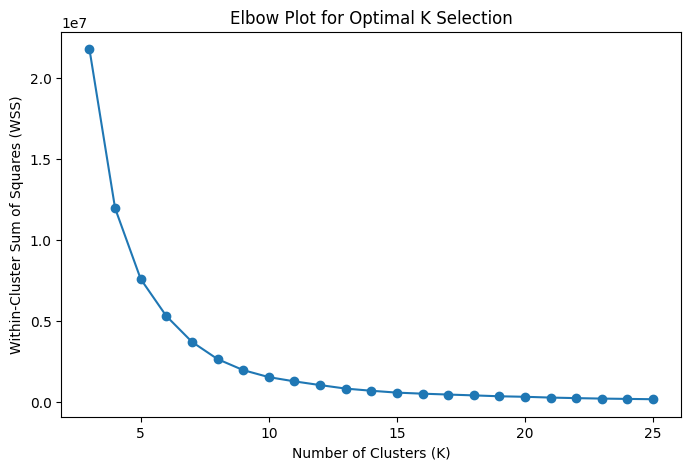

In [102]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [103]:
# Setting a K of 19 and placing players into relative value tiers
final_df = segment_players(value_df, k = 19)

In [104]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'relative_value', 'overall_ranking', 'position_rank', 'player_value_tier']]

In [105]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)